# Import Module

In [ ]:
import re
import time
import nltk
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt_tab')

lm = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# Dataset

In [ ]:
# 讀取 IMDB 評論數據
df = pd.read_csv(r"/content/drive/MyDrive/IMDB_Dataset.csv")
df = df.dropna() # 移除缺失值
df = df.sample(9000, random_state=666)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 9000 entries, 46334 to 34043
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     9000 non-null   object
 1   sentiment  9000 non-null   object
dtypes: object(2)
memory usage: 210.9+ KB
None


Original Method

In [ ]:
tqdm.pandas()

def transform_data(review):
    # 使用BeautifulSoup移除HTML標記
    review = BeautifulSoup(review, "html.parser").get_text()
    # 將文本轉換為小寫
    review = review.lower()
    # 移除非字母字符
    review = re.sub(r'[^a-zA-Z\s]', '', review)
    # 將文本分詞
    tokens = nltk.word_tokenize(review)
    # 進行詞形還原並移除停用詞
    review = [lm.lemmatize(token) for token in tokens if token not in stop_words]
    # 將處理後的單詞組合成一個文本字串
    review = " ".join(review)
    return review

# Applying the function with a progress bar
tranformed_rev_ori = df.review.progress_apply(transform_data)

  3%|▎         | 307/9000 [00:04<00:46, 186.54it/s]<ipython-input-5-b7b447a53725>:5: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  review = BeautifulSoup(review, "html.parser").get_text()
100%|██████████| 9000/9000 [00:27<00:00, 323.81it/s]


In [ ]:
# 特徵提取
tf = TfidfVectorizer()
lb = LabelEncoder()
X_ori = tf.fit_transform(tranformed_rev_ori).toarray()

y = lb.fit_transform(df.sentiment)

In [ ]:
# 切分訓練集和測試集
X_train_ori, X_test_ori, y_train_ori, y_test_ori = train_test_split(X_ori, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
print(X_train_ori.shape)
print(X_test_ori.shape)

(7200, 68672)
(1800, 68672)


# Training

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# 模型選擇
models = {
    'lr': LogisticRegression(),
    'rf': RandomForestClassifier(),
    'gs': GaussianNB(),
    'knn': KNeighborsClassifier()
}

In [ ]:
# 訓練多個模型並評估其表現
def fit_predict(models, X_train, y_train, X_test, y_test):
    y_pred = []
    models_name = []

    for model_name, model_obj in models.items():
        # 記錄開始時間
        start_time = time.time()
        print(f"Start training {model_name} at {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime())}...")

        # 訓練模型
        model_obj.fit(X_train, y_train)

        # 記錄結束時間
        end_time = time.time()
        elapsed_time = end_time - start_time  # 計算訓練時間

        print(f"{model_name} done at {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime())}....")
        print(f"End training {model_name}, Use time: {elapsed_time:.2f} seconds\n")

        # 預測測試數據
        y_pred.append(model_obj.predict(X_test))
        models_name.append(model_name)

    return y_pred, models_name

# Train

In [ ]:
y_pred_ori, models_name_ori = fit_predict(models, X_train_ori, y_train_ori, X_test_ori, y_test_ori)

Start training lr at 2024-12-10 12:17:54...
lr done at 2024-12-10 12:18:07....
End training lr, Use time: 13.25 seconds

Start training rf at 2024-12-10 12:18:07...
rf done at 2024-12-10 12:19:48....
End training rf, Use time: 100.80 seconds

Start training gs at 2024-12-10 12:19:49...
gs done at 2024-12-10 12:20:03....
End training gs, Use time: 14.03 seconds

Start training knn at 2024-12-10 12:20:05...
knn done at 2024-12-10 12:20:05....
End training knn, Use time: 0.39 seconds



# Model's Score

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

def get_score(y_pred, y_test):
    score = [accuracy_score(y_test, y) for y in y_pred]
    return score

<ipython-input-13-bda45aff0484>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x='models', y='score', data=md_scores_sorted, palette='rocket')


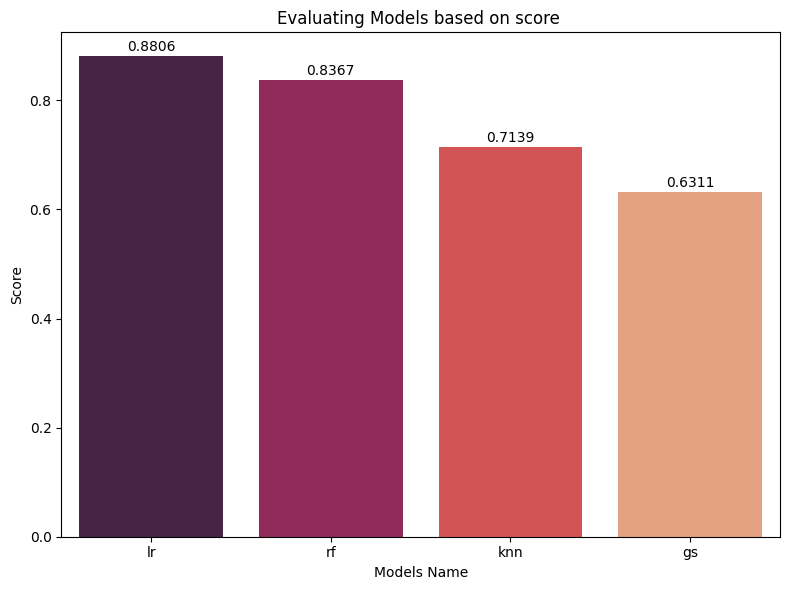

In [ ]:
# 計算模型的得分
score = get_score(y_pred_ori, y_test_ori)

# 創建包含模型名稱和分數的 DataFrame
md_scores = pd.DataFrame({'models': models_name_ori, 'score': score})

md_scores_sorted = md_scores.sort_values(by='score', ascending=False)

# 繪製柱狀圖，並將分數顯示在每個柱上
plt.figure(figsize=(8, 6))
bars = sns.barplot(x='models', y='score', data=md_scores_sorted, palette='rocket')

# 在每個柱上顯示分數（從已排序的 DataFrame 中讀取分數資料）
for bar, value in zip(bars.patches, md_scores_sorted['score']):
    bars.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, round(value, 4), ha='center', color='black', fontsize=10)

plt.title('Evaluating Models based on score ')
plt.xlabel('Models Name')
plt.ylabel('Score')
plt.tight_layout()
plt.show()

In [ ]:
# 定義繪製混淆矩陣和分類報告的函數
def plot_evaluation_metrics(model, X_test, y_test):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
    plt.title('Confusion Matrix')
    plt.show()
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

Evaluating Model: lr


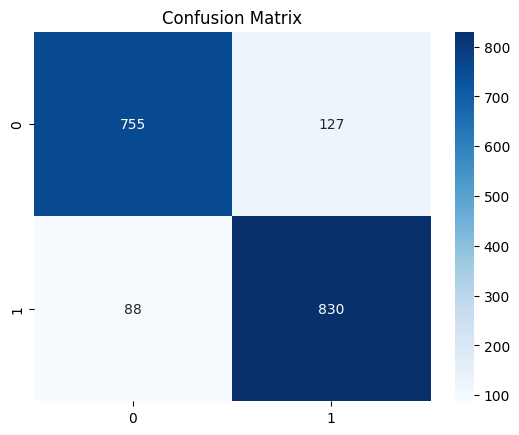

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.86      0.88       882
           1       0.87      0.90      0.89       918

    accuracy                           0.88      1800
   macro avg       0.88      0.88      0.88      1800
weighted avg       0.88      0.88      0.88      1800

Evaluating Model: rf


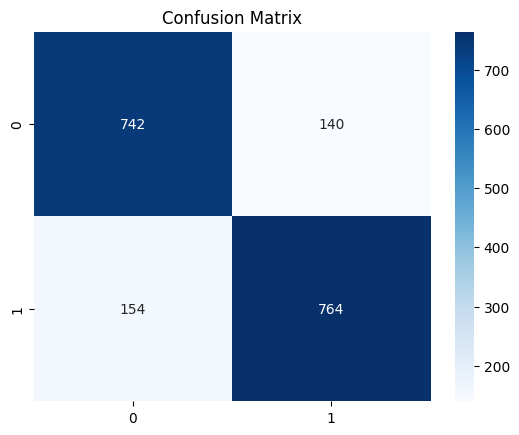

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.84      0.83       882
           1       0.85      0.83      0.84       918

    accuracy                           0.84      1800
   macro avg       0.84      0.84      0.84      1800
weighted avg       0.84      0.84      0.84      1800

Evaluating Model: gs


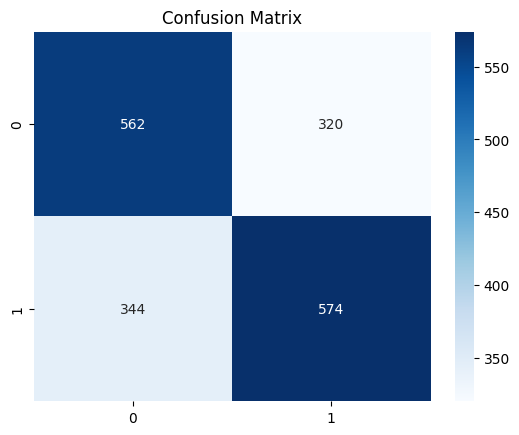

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.64      0.63       882
           1       0.64      0.63      0.63       918

    accuracy                           0.63      1800
   macro avg       0.63      0.63      0.63      1800
weighted avg       0.63      0.63      0.63      1800

Evaluating Model: knn


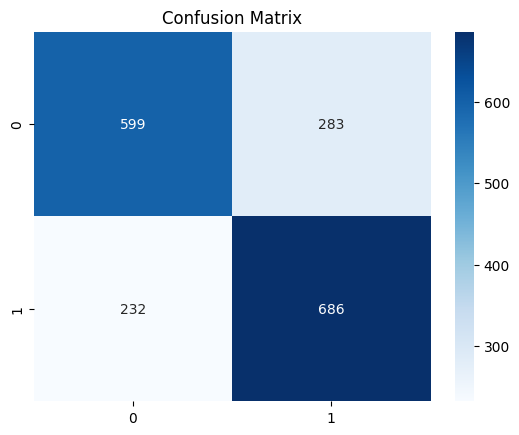

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.68      0.70       882
           1       0.71      0.75      0.73       918

    accuracy                           0.71      1800
   macro avg       0.71      0.71      0.71      1800
weighted avg       0.71      0.71      0.71      1800



In [ ]:
for model_name, model_obj in models.items():
    print(f"Evaluating Model: {model_name}")
    plot_evaluation_metrics(model_obj, X_test_ori, y_test_ori)